In [1]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]


In [261]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob

In [316]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    scale_fe=0.250019907951355/0.35828184923028494
    scale_o=0.10861970484256744/0.09543676896214373
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
    return data


def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

import matplotlib
from scipy import interpolate
from scipy.interpolate import interp1d
def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange[:-1]), vmax=max(vrange[:-1]))
    return [cmap(norm(i)) for i in vrange]

In [317]:
agepickle = readsimdata(simsnames[4],True, 15, 5)

for i in [4]:
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    redshifts = np.zeros(len(sortage))
    allages_rs = np.zeros(len(redshifts))
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
        try:
            redshifts[j] = pb.analysis.cosmology.redshift(s, ages)
        except:
            redshifts[j] = 0

g2.79e12_3x6


 98%|█████████▊| 224/229 [00:27<00:00,  8.29it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/pynbody/analysis/cosmology.py:21: RuntimeWarning: invalid value encountered in sqrt
  return h0 * a * np.sqrt(om_m * (a ** -3) + om_k * (a ** -2) + om_l)
/data/shared_data/anaconda3/lib/python3.8/site-packages/pynbody/analysis/cosmology.py:171: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(_a_dot_recip, 0, x, (h0, omM, omL))[0] * conv
100%|██████████| 229/229 [00:28<00:00,  8.17it/s]


(array([4.97, 4.9 , 4.83, 4.76, 4.69, 4.62, 4.55, 4.48, 4.41, 4.34, 4.27,
        4.2 , 4.13, 4.1 , 4.  , 3.9 , 3.8 , 3.8 , 3.7 , 3.6 , 3.6 , 3.5 ,
        3.4 , 3.3 , 3.3 , 3.2 , 3.1 , 3.1 ]),
 array([0.43060657, 0.42192995, 0.41335062, 0.40486665, 0.39647615,
        0.38817732, 0.37996838, 0.37184761, 0.36381332, 0.35586389,
        0.34799773, 0.34021327, 0.33250903, 0.3292314 , 0.31840897,
        0.30774188, 0.29722617, 0.29722617, 0.28685802, 0.27663377,
        0.27663377, 0.26654986, 0.25660287, 0.24678949, 0.24678949,
        0.23710653, 0.2275509 , 0.2275509 ]))

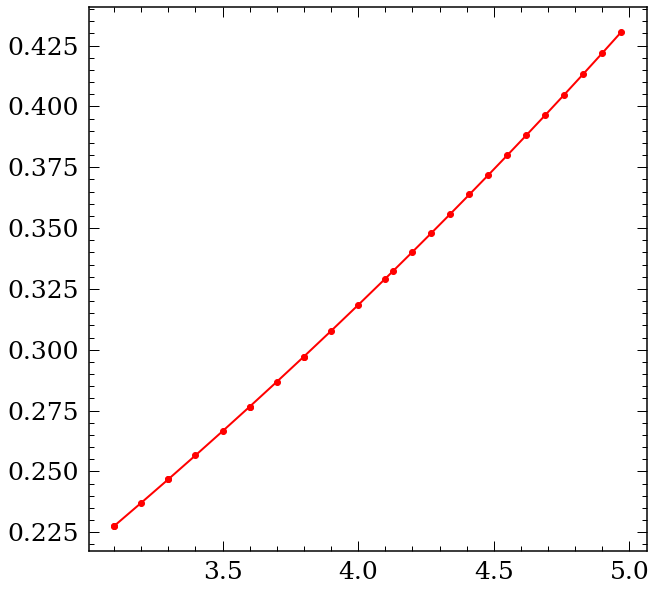

In [318]:
allages_rs = 14.1-allages_rs
m = np.array((allages_rs>3)&(allages_rs<5), dtype = bool)
plt.plot(allages_rs[m], redshifts[m], 'ro-')
allages_rs[m], redshifts[m]

In [319]:
    
# pick out stars between redshift 0.3-0.4
redshifts, sortage, allages_rs = zip(*sorted(zip(np.array(redshifts)[m], np.array(sortage)[m], np.array(allages_rs)[m])))
redshifts, sortage, allages_rs = redshifts[::-1], sortage[::-1], allages_rs[::-1]


In [367]:
from os.path import exists

print(len(redshifts))
cols = ['iord','r','z']
meanfeh = np.zeros(len(redshifts)-1)
stdfeh = np.zeros(len(redshifts)-1)
redshift_feh = np.zeros(len(redshifts)-1)
for j in trange(len(redshifts)-1):
    if j==0:
        print('reading ',snaplookup[sortage[j]])
        if exists(snaplookup[sortage[j]]+'.pkl'):
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
        else:
            s = pb.load(snaplookup[sortage[j]])
            h=s.halos()
            pb.analysis.angmom.faceon(h[1])
            s.physical_units()

            sim = h[1]

            stars = sim.s
            this_snap = pd.DataFrame({k:stars[k] for k in cols})
            this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh_scale','Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
            this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        # next snapshot
        print('reading ',snaplookup[sortage[j+1]])
        if exists(snaplookup[sortage[j+1]]+'.pkl'):
            this_snap1 = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')
        else:
            s1 = pb.load(snaplookup[sortage[j+1]])
            h1=s1.halos()
            pb.analysis.angmom.faceon(h1[1])
            s1.physical_units()

            sim1 = h1[1]

            stars1 = sim1.s
            this_snap1 = pd.DataFrame({k:stars1[k] for k in cols})
            this_snap1 = pd.merge(this_snap1, agepickle[['iord', 'age', 'feh_scale','Rbir','zbir','decomp']], left_on='iord', right_on='iord', how='inner')
            this_snap1.to_pickle(snaplookup[sortage[j+1]]+'.pkl')
    else:
        this_snap = this_snap1.copy(deep=True)

        # next snapshot
        print('reading ',snaplookup[sortage[j+1]])
        if exists(snaplookup[sortage[j+1]]+'.pkl'):
            this_snap1 = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')
        else:
            s1 = pb.load(snaplookup[sortage[j+1]])
            h1=s1.halos()
            pb.analysis.angmom.faceon(h1[1])
            s1.physical_units()

            sim1 = h1[1]

            stars1 = sim1.s
            this_snap1 = pd.DataFrame({k:stars1[k] for k in cols})
            this_snap1 = pd.merge(this_snap1, agepickle[['iord', 'age', 'feh_scale','Rbir','zbir','decomp']], left_on='iord', right_on='iord', how='inner')
            this_snap1.to_pickle(snaplookup[sortage[j+1]]+'.pkl')
            
    print('stars in snapshot z = %.4f:'%redshifts[j],len(this_snap),', stars in snapshot z = %.4f:'%redshifts[j+1],len(this_snap1))
    # find new born stars
    newstars = this_snap1.loc[~(this_snap1['iord'].isin(this_snap['iord']))]
    newstars = newstars.loc[abs(newstars['r']-8)<1]
    newstars = newstars.loc[abs(newstars['z'])<0.5]
    newstars = newstars.loc[(newstars['age']<6)].reset_index(drop=True)
    redshift_feh[j] = redshifts[j]
    meanfeh[j] = np.mean(newstars['feh_scale'])
    stdfeh[j] = np.std(newstars['feh_scale'])
    print('new stars born:', len(newstars), ', mean age:', np.mean(newstars['age'].dropna()),', mean feh:', np.mean(newstars['feh_scale'].dropna()))
    

    # plot
    #plt.hist(newstars['feh_scale'], bins=np.linspace(-1, 0.5, 50), color = colors[j], alpha = 0.2, density=True)
    
#plt.ylim([2, 14])
#plt.xlim([-1, 0.5])
#cb = plt.colorbar()
#cb.set_label('redshift')

28


  0%|          | 0/27 [00:00<?, ?it/s]

reading  g2.79e12_3x6/2.79e12.01290
reading  g2.79e12_3x6/2.79e12.01300
stars in snapshot z = 0.4306: 1967421 , stars in snapshot z = 0.4219: 1977741


  4%|▎         | 1/27 [00:03<01:30,  3.47s/it]

new stars born: 976 , mean age: 4.978423321476931 , mean feh: 0.10555058619459089
reading  g2.79e12_3x6/2.79e12.01310
stars in snapshot z = 0.4219: 1977741 , stars in snapshot z = 0.4134: 1987185


  7%|▋         | 2/27 [00:06<01:23,  3.34s/it]

new stars born: 1163 , mean age: 4.911278458652914 , mean feh: 0.10882348166931427
reading  g2.79e12_3x6/2.79e12.01320
stars in snapshot z = 0.4134: 1987185 , stars in snapshot z = 0.4049: 1996198


 11%|█         | 3/27 [00:10<01:23,  3.46s/it]

new stars born: 741 , mean age: 4.836191349791945 , mean feh: 0.12414149796979919
reading  g2.79e12_3x6/2.79e12.01330
stars in snapshot z = 0.4049: 1996198 , stars in snapshot z = 0.3965: 2005928


 15%|█▍        | 4/27 [00:13<01:20,  3.51s/it]

new stars born: 942 , mean age: 4.760517056585073 , mean feh: 0.13616280283358786
reading  g2.79e12_3x6/2.79e12.01340
stars in snapshot z = 0.3965: 2005928 , stars in snapshot z = 0.3882: 2014946


 19%|█▊        | 5/27 [00:17<01:16,  3.47s/it]

new stars born: 722 , mean age: 4.6980390547218285 , mean feh: 0.12389016437302053
reading  g2.79e12_3x6/2.79e12.01350
stars in snapshot z = 0.3882: 2014946 , stars in snapshot z = 0.3800: 2023969


 22%|██▏       | 6/27 [00:21<01:17,  3.67s/it]

new stars born: 778 , mean age: 4.626285541344033 , mean feh: 0.12409937005187524
reading  g2.79e12_3x6/2.79e12.01360
stars in snapshot z = 0.3800: 2023969 , stars in snapshot z = 0.3718: 2032005


 26%|██▌       | 7/27 [00:24<01:10,  3.51s/it]

new stars born: 384 , mean age: 4.546594312280664 , mean feh: 0.15755582752204297
reading  g2.79e12_3x6/2.79e12.01370
stars in snapshot z = 0.3718: 2032005 , stars in snapshot z = 0.3638: 2042015


 30%|██▉       | 8/27 [00:26<00:56,  2.99s/it]

new stars born: 681 , mean age: 4.486060498905012 , mean feh: 0.130109214329452
reading  g2.79e12_3x6/2.79e12.01380
stars in snapshot z = 0.3638: 2042015 , stars in snapshot z = 0.3559: 2050794


 33%|███▎      | 9/27 [00:29<00:52,  2.91s/it]

new stars born: 617 , mean age: 4.409731138870223 , mean feh: 0.14338538563085085
reading  g2.79e12_3x6/2.79e12.01390
stars in snapshot z = 0.3559: 2050794 , stars in snapshot z = 0.3480: 2059913


 37%|███▋      | 10/27 [00:34<01:04,  3.77s/it]

new stars born: 909 , mean age: 4.34257530925288 , mean feh: 0.13684291439527796
reading  g2.79e12_3x6/2.79e12.01400
stars in snapshot z = 0.3480: 2059913 , stars in snapshot z = 0.3402: 2068260


 41%|████      | 11/27 [00:39<01:05,  4.07s/it]

new stars born: 475 , mean age: 4.280175623633623 , mean feh: 0.16633061373361394
reading  g2.79e12_3x6/2.79e12.01410
stars in snapshot z = 0.3402: 2068260 , stars in snapshot z = 0.3325: 2076084


 44%|████▍     | 12/27 [00:45<01:08,  4.56s/it]

new stars born: 569 , mean age: 4.206969753783249 , mean feh: 0.15234025688248032
reading  g2.79e12_3x6/2.79e12.01420
stars in snapshot z = 0.3325: 2076084 , stars in snapshot z = 0.3292: 2086380


 48%|████▊     | 13/27 [00:52<01:13,  5.22s/it]

new stars born: 1225 , mean age: 4.123271359632129 , mean feh: 0.11669647335299883
reading  g2.79e12_3x6/2.79e12.01430
stars in snapshot z = 0.3292: 2086380 , stars in snapshot z = 0.3184: 2094881


 52%|█████▏    | 14/27 [00:56<01:06,  5.09s/it]

new stars born: 660 , mean age: 4.066768897586687 , mean feh: 0.16262967773797532
reading  g2.79e12_3x6/2.79e12.01440
stars in snapshot z = 0.3184: 2094881 , stars in snapshot z = 0.3077: 2104690


 56%|█████▌    | 15/27 [01:00<00:57,  4.79s/it]

new stars born: 919 , mean age: 3.985334814857124 , mean feh: 0.1532015404479981
reading  g2.79e12_3x6/2.79e12.01460
stars in snapshot z = 0.3077: 2104690 , stars in snapshot z = 0.2972: 2125280


 59%|█████▉    | 16/27 [01:04<00:47,  4.36s/it]

new stars born: 1567 , mean age: 3.893835671920934 , mean feh: 0.13905281749277706
reading  g2.79e12_3x6/2.79e12.01450
stars in snapshot z = 0.2972: 2125280 , stars in snapshot z = 0.2972: 2114738


 63%|██████▎   | 17/27 [01:06<00:37,  3.70s/it]

new stars born: 0 , mean age: nan , mean feh: nan
reading  g2.79e12_3x6/2.79e12.01470
stars in snapshot z = 0.2972: 2114738 , stars in snapshot z = 0.2869: 2138106


 67%|██████▋   | 18/27 [01:08<00:29,  3.28s/it]

new stars born: 1438 , mean age: 3.8205363525900737 , mean feh: 0.12378206640657284
reading  g2.79e12_3x6/2.79e12.01490
stars in snapshot z = 0.2869: 2138106 , stars in snapshot z = 0.2766: 2166918


 70%|███████   | 19/27 [01:11<00:23,  2.98s/it]

new stars born: 2038 , mean age: 3.6718334561735646 , mean feh: 0.06957314546157423
reading  g2.79e12_3x6/2.79e12.01480
stars in snapshot z = 0.2766: 2166918 , stars in snapshot z = 0.2766: 2152131


 74%|███████▍  | 20/27 [05:28<09:16, 79.48s/it]

new stars born: 0 , mean age: nan , mean feh: nan
reading  g2.79e12_3x6/2.79e12.01500
stars in snapshot z = 0.2766: 2152131 , stars in snapshot z = 0.2665: 2182975


 78%|███████▊  | 21/27 [08:04<10:13, 102.32s/it]

new stars born: 3127 , mean age: 3.598529490809829 , mean feh: 0.06333488604649547
reading  g2.79e12_3x6/2.79e12.01510
stars in snapshot z = 0.2665: 2182975 , stars in snapshot z = 0.2566: 2198900


 81%|████████▏ | 22/27 [12:55<13:15, 159.13s/it]

new stars born: 1769 , mean age: 3.4901737073702295 , mean feh: 0.038996174456071876
reading  g2.79e12_3x6/2.79e12.01530
stars in snapshot z = 0.2566: 2198900 , stars in snapshot z = 0.2468: 2232932


 85%|████████▌ | 23/27 [15:47<10:51, 162.90s/it]

new stars born: 3411 , mean age: 3.393344050862957 , mean feh: 0.04959482351267489
reading  g2.79e12_3x6/2.79e12.01520
stars in snapshot z = 0.2468: 2232932 , stars in snapshot z = 0.2468: 2217322


 89%|████████▉ | 24/27 [18:25<08:03, 161.29s/it]

new stars born: 0 , mean age: nan , mean feh: nan
reading  g2.79e12_3x6/2.79e12.01540
stars in snapshot z = 0.2468: 2217322 , stars in snapshot z = 0.2371: 2251823


 93%|█████████▎| 25/27 [22:15<06:04, 182.03s/it]

new stars born: 3082 , mean age: 3.318191319174938 , mean feh: 0.05312059329016275
reading  g2.79e12_3x6/2.79e12.01560
stars in snapshot z = 0.2371: 2251823 , stars in snapshot z = 0.2276: 2286032


 96%|█████████▋| 26/27 [27:55<03:49, 229.34s/it]

new stars born: 3947 , mean age: 3.17234734308414 , mean feh: 0.03678700919644449
reading  g2.79e12_3x6/2.79e12.01550
stars in snapshot z = 0.2276: 2286032 , stars in snapshot z = 0.2276: 2267396


100%|██████████| 27/27 [31:34<00:00, 70.17s/it] 

new stars born: 0 , mean age: nan , mean feh: nan


In [372]:
#(np.array(allages_rs[1:])+np.array(allages_rs[:-1]))/2

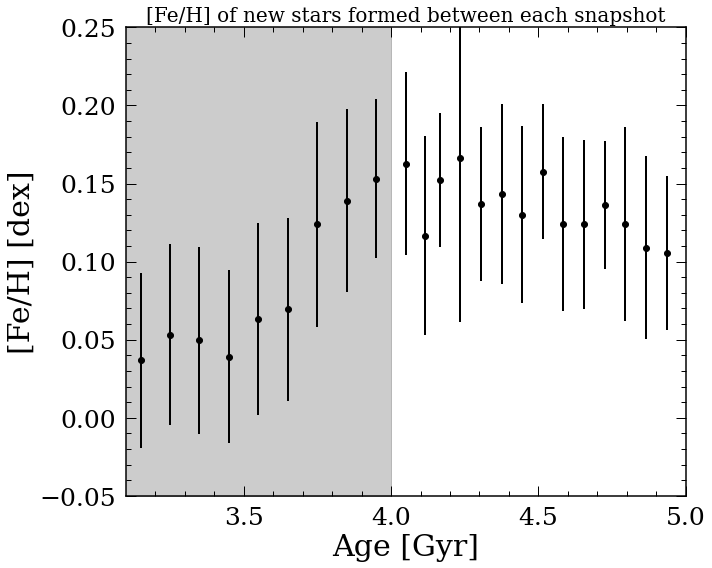

In [387]:
xage = (np.array(allages_rs[1:])+np.array(allages_rs[:-1]))/2
plt.figure(figsize=(10,8))
plt.errorbar(xage, meanfeh, yerr=stdfeh, fmt='ko')
plt.fill_between([3, 4], [-0.05, -0.05], y2=0.3 ,color='k', alpha=0.2)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.ylim([-0.05, -0.05+0.3])
plt.xlim([3.1,5])
plt.title('[Fe/H] of new stars formed between each snapshot',fontsize=20)
plt.tight_layout()
plt.savefig('fehsnapshot.png')

In [ ]:
#5210781
len(agepickle)

In [343]:
s = pb.load(snaplookup[1430])
h=s.halos()
pb.analysis.angmom.faceon(h[1])
s.physical_units()

sim = h[1]

stars = sim.s
this_snap = pd.DataFrame({k:stars[k] for k in cols})
this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh_scale','Rbir','zbir','decomp']], left_on='iord', right_on='iord', how='inner')
this_snap.to_pickle(snaplookup[1430]+'.pkl')


In [344]:
s1 = pb.load(snaplookup[1570])
h1=s1.halos()
pb.analysis.angmom.faceon(h1[1])
s1.physical_units()

sim1 = h1[1]

stars1 = sim1.s
this_snap1 = pd.DataFrame({k:stars1[k] for k in cols})
this_snap1 = pd.merge(this_snap1, agepickle[['iord', 'age', 'feh_scale','Rbir','zbir','decomp']], left_on='iord', right_on='iord', how='inner')
this_snap1.to_pickle(snaplookup[1570]+'.pkl')



In [345]:
newstars = this_snap1.loc[~(this_snap1['iord'].isin(this_snap['iord'].values))]

newstars


,iord,r,z,age,feh_scale,Rbir,zbir,decomp
2094881,45705536,8.776078,-0.616017,4.024058,0.060145,8.589427,0.461696,4
2094882,45705537,9.500857,-0.679277,4.024058,0.062435,8.745449,0.351029,4
2094883,45705538,13.374294,-2.041340,4.024058,-0.024249,13.797297,-0.059080,4
2094884,45705539,12.960760,-1.902813,4.024058,-0.015858,13.431702,0.060331,4
2094885,45705549,2.891767,0.030518,4.024058,0.279994,4.432331,-0.160408,1
...,...,...,...,...,...,...,...,...
2301030,46243860,2.741684,0.073710,3.036362,0.124952,2.740024,0.066165,1
2301031,46243861,2.765131,-0.086514,3.036362,0.123079,2.762760,-0.093998,1
2301032,46243874,3.537736,-0.058771,3.036362,0.156272,3.538082,-0.057191,1
2301033,46243875,3.424857,-0.089248,3.036362,0.192531,3.424564,-0.087671,4


In [346]:
newstars['age']

2094881    4.024058
2094882    4.024058
2094883    4.024058
2094884    4.024058
2094885    4.024058
             ...   
2301030    3.036362
2301031    3.036362
2301032    3.036362
2301033    3.036362
2301034    3.036362
Name: age, Length: 206154, dtype: float64